In [1]:
import time
from datasets import *
from seqstein import *
from pprreg import *
from sklearn.neural_network import MLPRegressor

In [2]:
def visual_model(betas,model_list,train_x,
                 intercepts=0,
                 show_top=None,
                 figsize=None,
                 show_indices=20,
                 cols_per_row=3):

    subfig_idx = 0
    max_ids = 10
    fig = plt.figure(figsize=(8 * cols_per_row, 4.6 * int(np.ceil(max_ids / cols_per_row))))
    outer = gridspec.GridSpec(int(np.ceil(max_ids / cols_per_row)), cols_per_row, wspace=0.15, hspace=0.25)

    xgrids = np.dot(train_x,betas.T)+intercepts
    ir = np.std(np.array([model(xgrids[:,idx]) for idx, model in enumerate(model_list)]),axis=1)
    ir = ir/np.sum(ir)
    ir_indices = np.argsort(-ir)

    if betas.shape[1] > 0:
        xlim_min = - max(np.abs(betas.min() - 0.1), np.abs(betas.max() + 0.1))
        xlim_max = max(np.abs(betas.min() - 0.1), np.abs(betas.max() + 0.1))

    if show_top is None:
        ir_indices = ir_indices
    else:
        ir_indices = ir_indices[:show_top]
        
    for idx, ir_idx in enumerate(ir_indices):
        model = model_list[ir_idx]
        importance_ratio = ir[ir_idx]

        inner = outer[subfig_idx].subgridspec(2, 2, wspace=0.2, height_ratios=[6, 1], width_ratios=[3, 1])
        ax1_main = fig.add_subplot(inner[0, 0])
        xgrid = xgrids[:,ir_idx]
        ygrid = model(xgrid)
        ax1_main.plot(xgrid[xgrid.argsort()], ygrid[xgrid.argsort()], color="red")
        ax1_main.set_xticklabels([])
        ax1_main.set_title("SIM " + str(ir_idx+1) +
                     " (IR: " + str(np.round(100 * importance_ratio, 2)) + "%)",
                     fontsize=16)
        fig.add_subplot(ax1_main)

        ax1_density = fig.add_subplot(inner[1, 0])  
        ax1_density.hist(xgrid)
        ax1_main.get_shared_x_axes().join(ax1_main, ax1_density)
        ax1_density.set_yticklabels([])
        fig.add_subplot(ax1_density)

        ax2 = fig.add_subplot(inner[:, 1])

        if betas.shape[1] < 20:
                rects = ax2.barh(np.arange(len(betas[ir_idx,:])), [beta for beta in betas[ir_idx,:].ravel()][::-1])
                ax2.set_yticks(np.arange(len(betas[ir_idx,:])))
                ax2.set_yticklabels(["X" + str(idx + 1) for idx in range(len(betas[ir_idx,:].ravel()))][::-1])
                ax2.set_xlim(xlim_min, xlim_max)
                ax2.set_ylim(-1, len(betas[ir_idx,:]))
                ax2.axvline(0, linestyle="dotted", color="black")
        else:
                input_ticks = np.arange(show_indices)[::-1]
                rects = plt.barh(np.arange(show_indices), [beta for beta in betas[ir_idx,:].ravel()][:show_indices][::-1])
                ax2.set_yticks(input_ticks)
                ax2.set_yticklabels(["X" + str(idx + 1) for idx in input_ticks][::-1])
                ax2.set_xlim(xlim_min, xlim_max)
                ax2.set_ylim(-1, min(len(betas[ir_idx,:]),show_indices))
                ax2.axvline(0, linestyle="dotted", color="black")
        fig.add_subplot(ax2)
        subfig_idx += 1

In [3]:
def plot_all_figures(data_loader,save_nm,data_type,figdir='./figures/',
                     show_indices=20,
                     random_state=0):

    betas, model_list, train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_loader(datanum=n,d=d,
                                                                                                        rand_seed=random_state)
    show_top=betas.shape[1]
    
            
    # SeqStein
    print('---------- SeqStein-Ortho ----------')
    clf = SeqStein(val_ratio=0.2,
                   reg_lambda=reg_lambda,
                   reg_gamma=reg_gamma,
                   knot_num=knot_num,
                   nterms=nterms_max,
                   early_stop_thres=1,
                   ortho_enhance=True,
                   random_state=random_state)
    clf.fit(train_x,train_y)

    clf.visualize(show_top=show_top, cols_per_row=show_top)
    plt.gcf()
    plt.savefig(figdir+save_nm+'-seqstein-ortho.pdf',bbox_inches = 'tight')
    plt.show()
    
    print('---------- SeqStein-NonOrtho ----------')
    clf = SeqStein(val_ratio=0.2,
                   reg_lambda=reg_lambda,
                   reg_gamma=reg_gamma,
                   knot_num=knot_num,
                   nterms=nterms_max,
                   early_stop_thres=1,
                   ortho_enhance=False,
                   random_state=random_state)
    clf.fit(train_x,train_y)

    clf.visualize(show_top=show_top, cols_per_row=show_top)
    plt.gcf()
    plt.savefig(figdir+save_nm+'-seqstein-nonortho.pdf',bbox_inches = 'tight')
    plt.show()

    # AIM-Low
    print('---------- AIM-Low ----------')
    clf = PPRRegressor(nterms=nterms_max_aimlow, opt_level="low",
                     knot_num=knot_num, 
                     reg_gamma=reg_gamma,
                     knot_dist=knot_dist, 
                     random_state=random_state)
    clf.fit(train_x, train_y)

    clf.visualize(show_top=show_top,show_indices=show_indices, cols_per_row=show_top)
    plt.gcf()
    plt.savefig(figdir+save_nm+'-pprlow.pdf',bbox_inches = 'tight')
    plt.show()

    # AIM-High
    print('---------- AIM-High ----------')
    clf = PPRRegressor(nterms=nterms_max_aimhigh, opt_level="high",
                         knot_num=knot_num, 
                         reg_gamma=reg_gamma,
                         knot_dist=knot_dist, 
                         random_state=random_state)
    clf.fit(train_x, train_y)
    clf.visualize(show_top=show_top,show_indices=show_indices, cols_per_row=show_top)

    plt.gcf()
    plt.savefig(figdir+save_nm+'-pprhigh.pdf',bbox_inches = 'tight')
    plt.show()

    # SLFN
    print('---------- SLFN ----------')
    datanum = train_x.shape[0]
    indices = np.arange(datanum)
    valnum = int(round(datanum * val_ratio))

    idx1, idx2 = train_test_split(indices, test_size=valnum, random_state=random_state)
    model = MLPRegressor(hidden_layer_sizes=(nterms_max_slfn), max_iter=2000, batch_size=min(1000, int(np.floor(datanum * 0.20))), \
                  activation="tanh", early_stopping=True,
                  random_state=random_state, validation_fraction=val_ratio, n_iter_no_change=100)
    model.fit(train_x[idx1, :], train_y[idx1].ravel())

    betas_slfn = model.coefs_[0]
    betas_slfn = betas_slfn / np.linalg.norm(betas_slfn, axis=0)
    betas_slfn = betas_slfn.T
    intercepts = model.intercepts_[0].reshape(1,-1)
    model_list_slfn = [np.tanh for i in range(nterms_max)]

    visual_model(betas_slfn,model_list_slfn,train_x,intercepts,show_top=show_top,show_indices=show_indices,
                 cols_per_row=show_top)

    plt.gcf()
    plt.savefig(figdir+save_nm+'-slfn.pdf',bbox_inches = 'tight')
    plt.show()
    
    
    print('---------- ExNN ----------')
    from exnn import ExNN
    import tensorflow as tf
    
    datanum, n_features = train_x.shape
    meta_info = {}
    for i in range(n_features):
        meta_info.update({"X" + str(i + 1):{"type":"continuous"}})
    meta_info.update({"Y":{"type":"target"}})

    model = ExNN(meta_info=meta_info,
           subnet_num=nterms_max,
           subnet_arch=[10, 6],
           task_type='Regression',
           activation_func=tf.tanh,
           batch_size=min(1000, int(train_x.shape[0] * 0.2)),
           training_epochs=5000,
           lr_bp=0.001,
           lr_cl=0.1,
           beta_threshold=0.1,
           tuning_epochs=100,
           l1_proj=1e-3,
           l1_subnet=1e-3,
           l2_smooth=10**(-6),
           verbose=False,
           val_ratio=0.2,
           early_stop_thres=500,
           random_state=random_state)
    
    start = time.time()
    model.fit(train_x, train_y)
    model.visualize_new(subnet_num=show_top, 
                        folder=figdir,
                        name=save_nm+'-exnn.pdf',
                        show_indices=show_indices, 
                        cols_per_row=show_top)
    
    plt.gcf()
    plt.savefig(figdir+save_nm+'-exnn.pdf',bbox_inches = 'tight')
    plt.show()

In [4]:
def plot_all_figures_real(data_loader,save_nm,
                          data_type,figdir='./figures/',
                         show_indices=20,
                         random_state=0):
    
    train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_loader(random_state=random_state)
            
    show_top=4
            
    # SeqStein
    print('---------- SeqStein-Ortho ----------')
    clf = SeqStein(val_ratio=0.2,
                   reg_lambda=reg_lambda,
                   reg_gamma=reg_gamma,
                   knot_num=knot_num,
                   nterms=nterms_max,
                   early_stop_thres=1,
                   ortho_enhance=True,
                   random_state=random_state)
    clf.fit(train_x,train_y)

    clf.visualize(show_top=show_top, 
                  cols_per_row=show_top,
                  show_indices=train_x.shape[1])
    plt.gcf()
    plt.savefig(figdir+save_nm+'-seqstein-ortho.pdf',bbox_inches = 'tight')
    plt.show()
    
    print('---------- SeqStein-NonOrtho ----------')
    clf = SeqStein(val_ratio=0.2,
                   reg_lambda=reg_lambda,
                   reg_gamma=reg_gamma,
                   knot_num=knot_num,
                   nterms=nterms_max,
                   early_stop_thres=1,
                   ortho_enhance=False,
                   random_state=random_state)
    clf.fit(train_x,train_y)

    clf.visualize(show_top=show_top, 
                  cols_per_row=show_top,
                  show_indices=train_x.shape[1])
    plt.gcf()
    plt.savefig(figdir+save_nm+'-seqstein-nonrotho.pdf',bbox_inches = 'tight')
    plt.show()

# Simulation Case 1

In [5]:
random_state = 0

n = int(1e4)

nterms_max_aimlow = 14 
nterms_max_aimhigh = 15
nterms_max = 20
nterms_max_slfn = 31
knot_num = 10
reg_lambda = [0.1,0.5,0.9]
reg_gamma = "GCV"
knot_dist = 'quantile'
val_ratio = 0.2

d = 20

figdir='./figures/'
save_nm = 'c1'
data_type = 'simulation'

In [6]:
data_loader = data_generator1
betas, model_list, train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_loader(datanum=n,d=d,rand_seed=random_state)

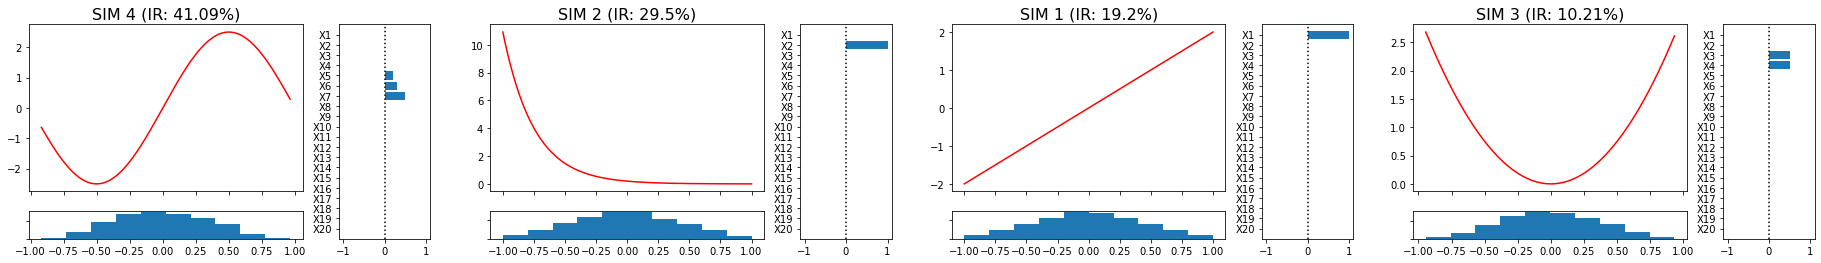

In [7]:
# ground truth
visual_model(betas.T, model_list, train_x, show_indices=20, cols_per_row=4)
plt.gcf()
plt.savefig(figdir+save_nm+'-truth.pdf',bbox_inches = 'tight')
plt.show()

---------- SeqStein-Ortho ----------


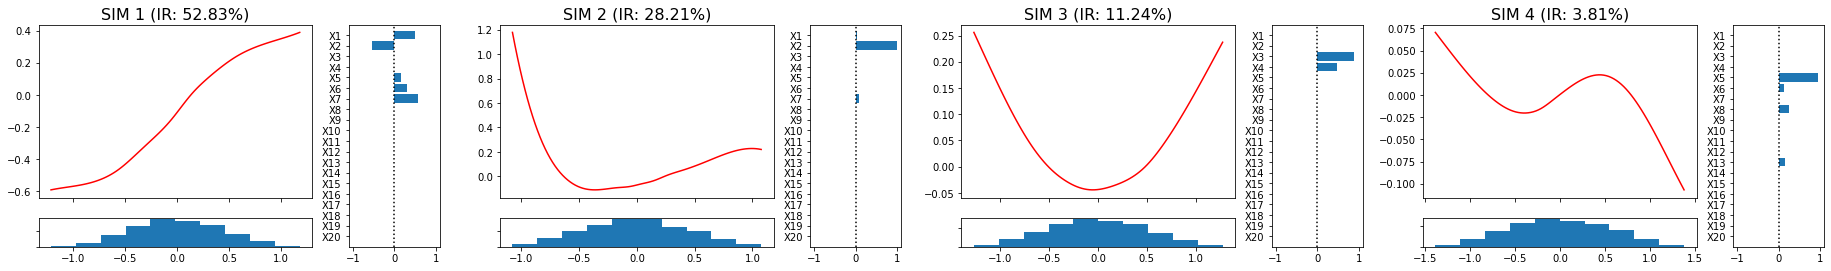

---------- SeqStein-NonOrtho ----------


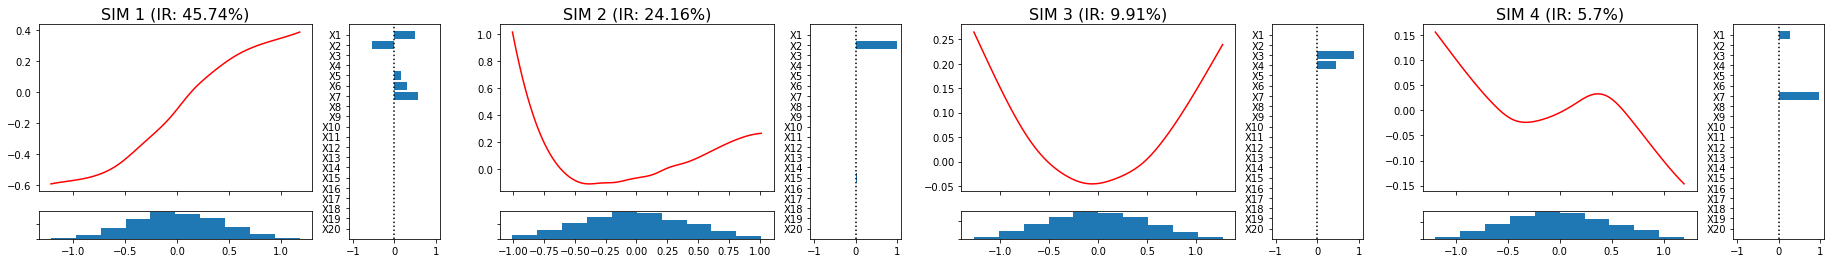

---------- AIM-Low ----------


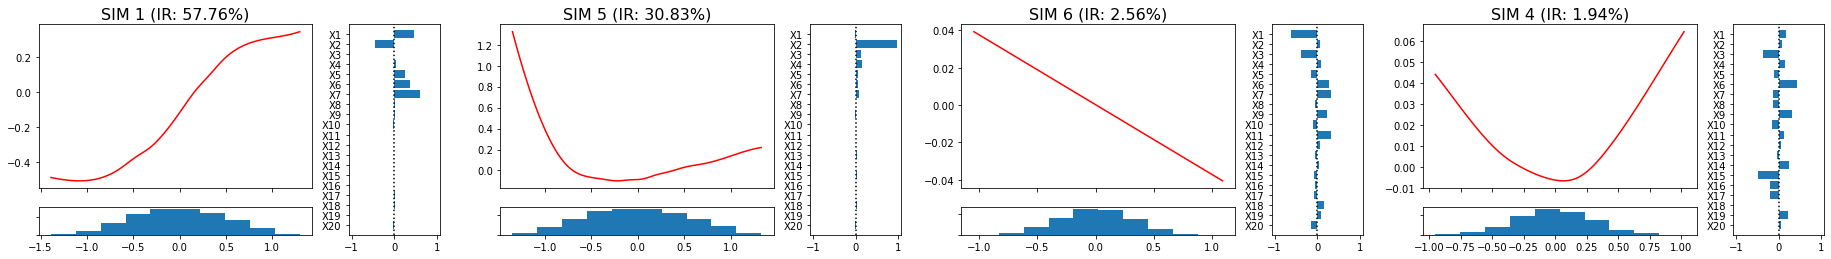

---------- AIM-High ----------


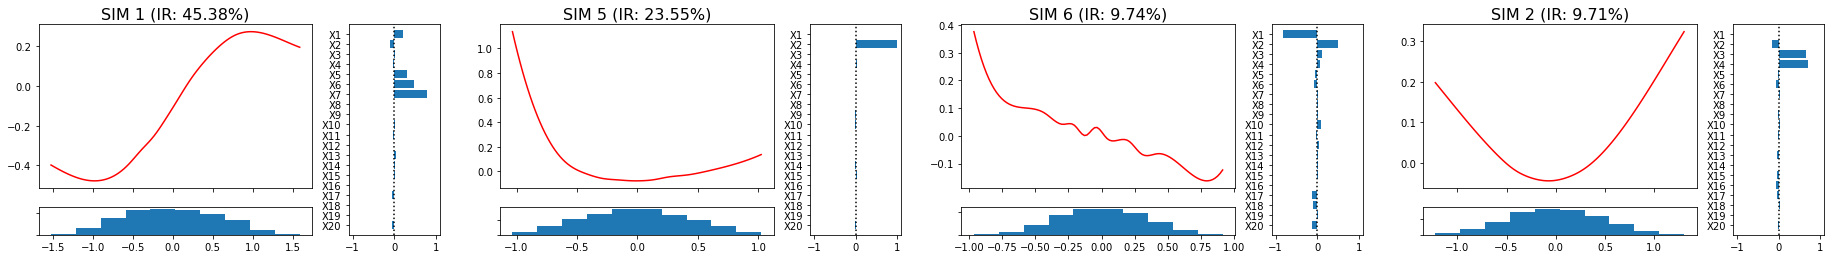

---------- SLFN ----------


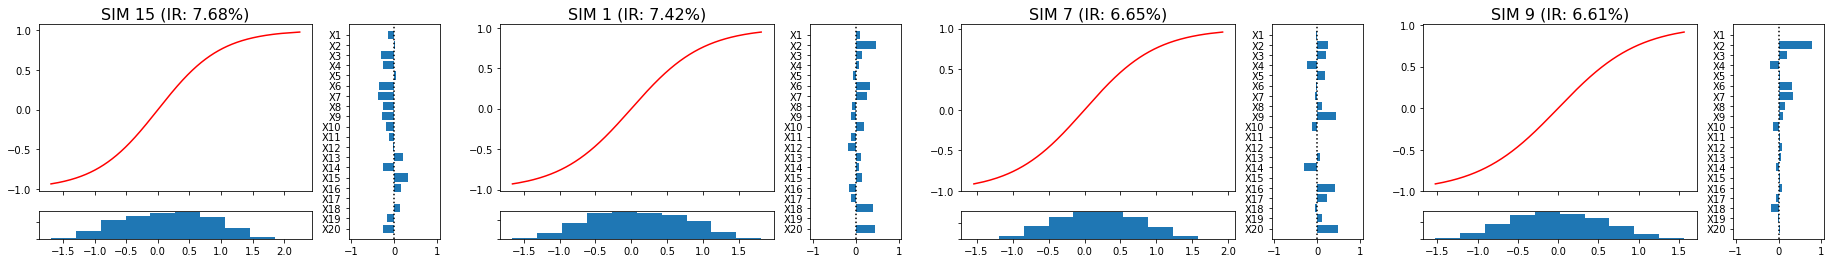

---------- ExNN ----------
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


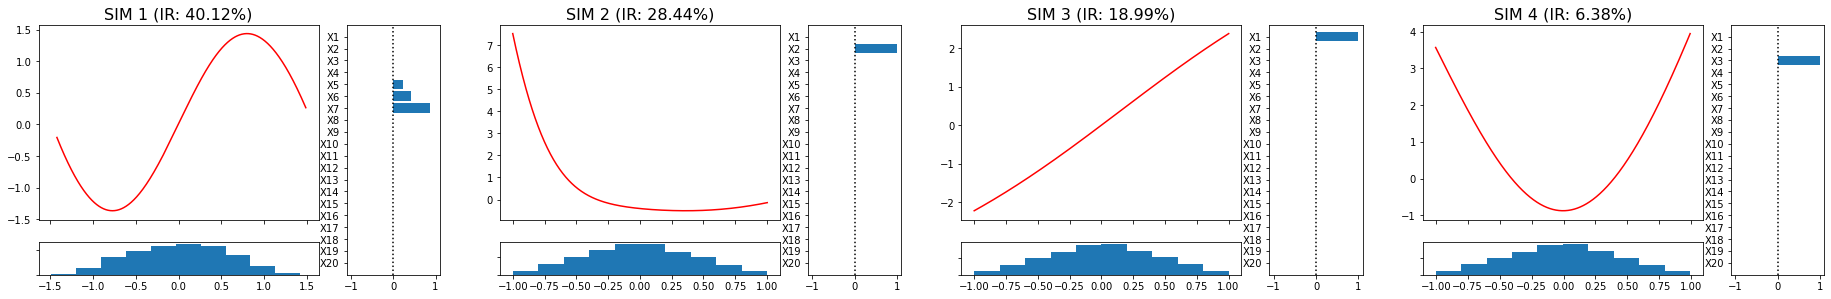

<Figure size 432x288 with 0 Axes>

In [8]:
plot_all_figures(data_loader,save_nm,data_type,figdir='./figures/',random_state=random_state)

# Simulation Case 2

In [9]:
random_state = 0

n = int(1e4)

nterms_max_aimlow = 14
nterms_max_aimhigh = 9
nterms_max = 20
nterms_max_slfn = 105
knot_num = 10
reg_lambda = [0.1,0.5,0.9]
reg_gamma = "GCV"
knot_dist = 'quantile'
val_ratio = 0.2

d = 20

figdir='./figures/'
save_nm = 'c2'
data_type = 'simulation'

In [10]:
data_loader = data_generator2
betas, model_list, train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_loader(datanum=n,d=d,rand_seed=random_state)

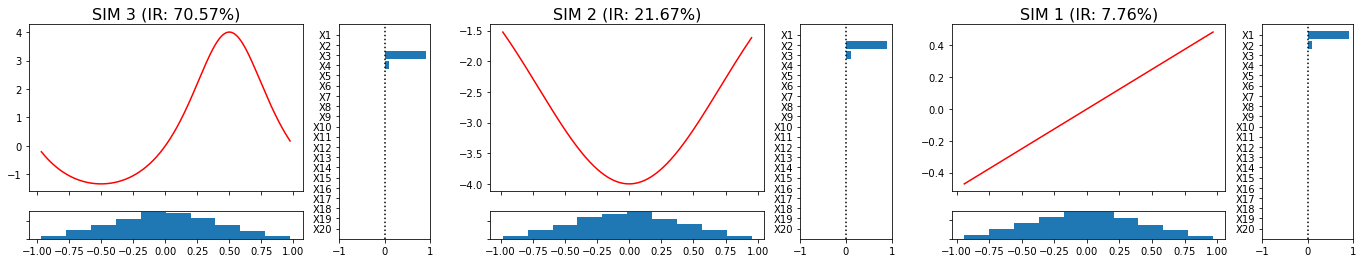

In [11]:
# ground truth
visual_model(betas.T, model_list, train_x, show_indices=20, cols_per_row=4)
plt.gcf()
plt.savefig(figdir+save_nm+'-truth.pdf',bbox_inches = 'tight')
plt.show()

---------- SeqStein-Ortho ----------


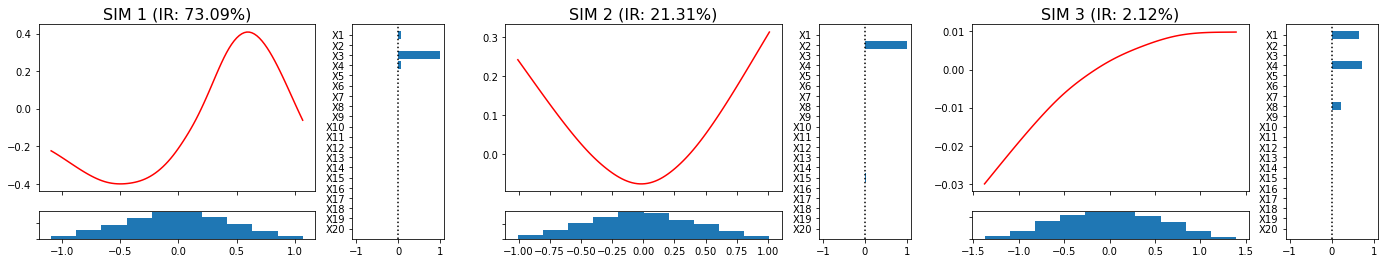

---------- SeqStein-NonOrtho ----------


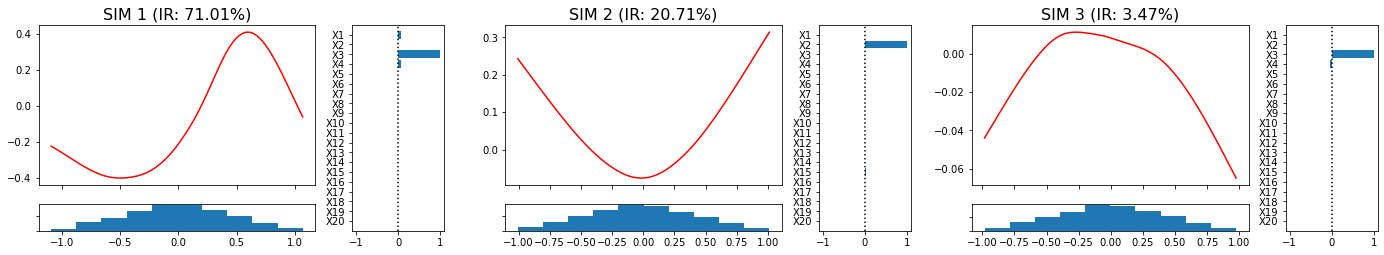

---------- AIM-Low ----------


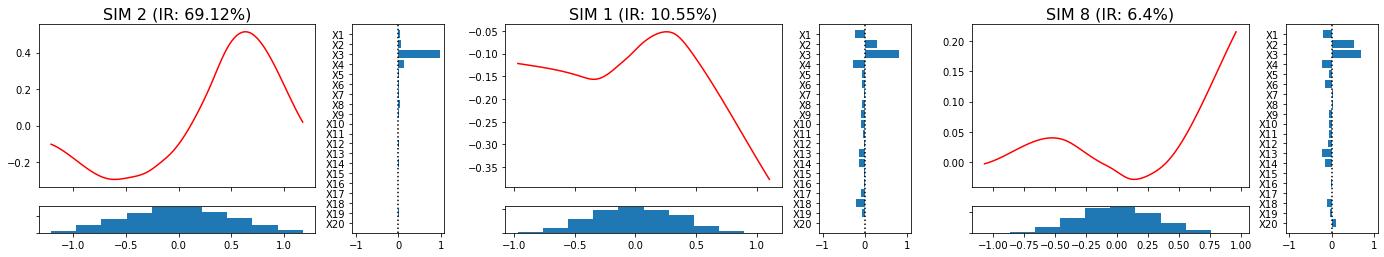

---------- AIM-High ----------


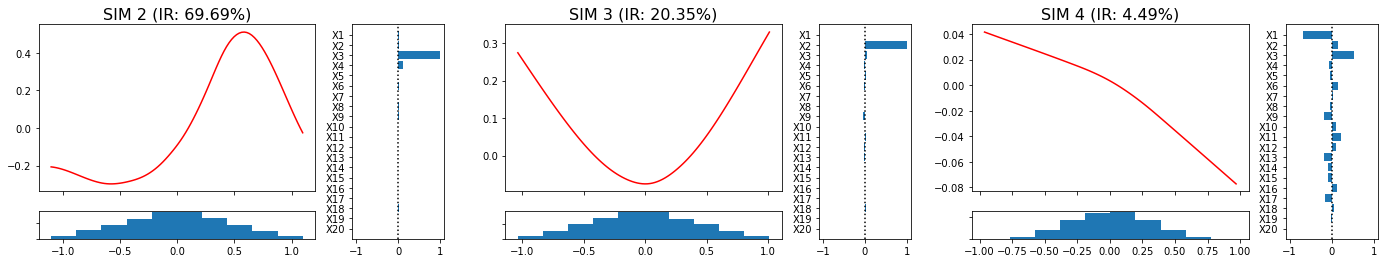

---------- SLFN ----------


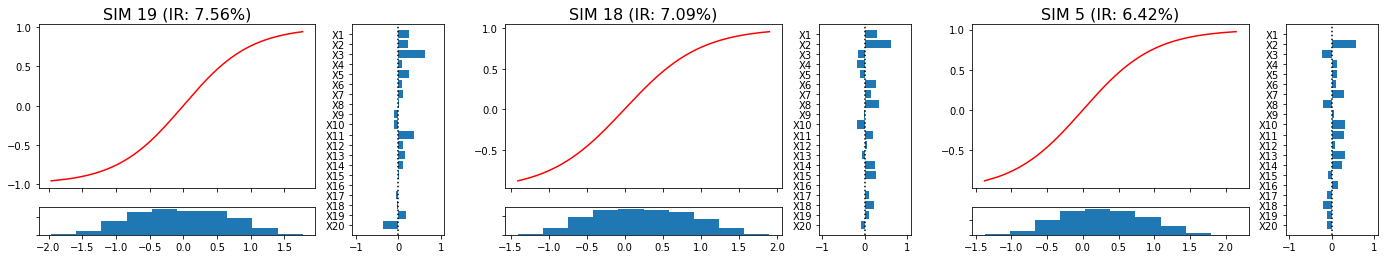

---------- ExNN ----------


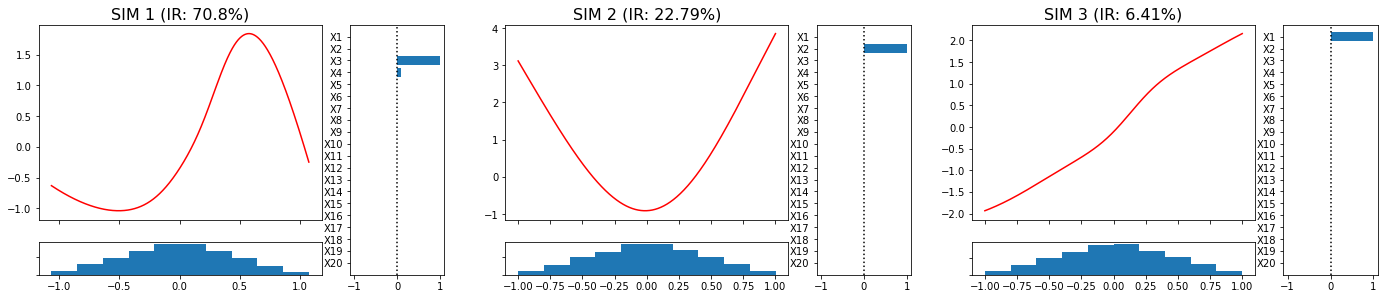

<Figure size 432x288 with 0 Axes>

In [12]:
plot_all_figures(data_loader,save_nm,
                 data_type,
                 figdir='./figures/',random_state=random_state)

# Real Data: Wine Red \& Wine White

---------- SeqStein-Ortho ----------


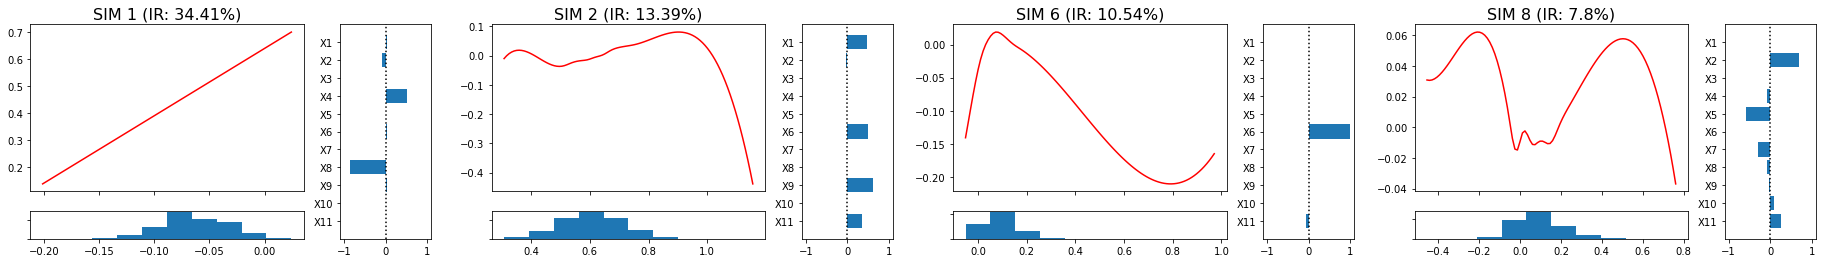

---------- SeqStein-NonOrtho ----------


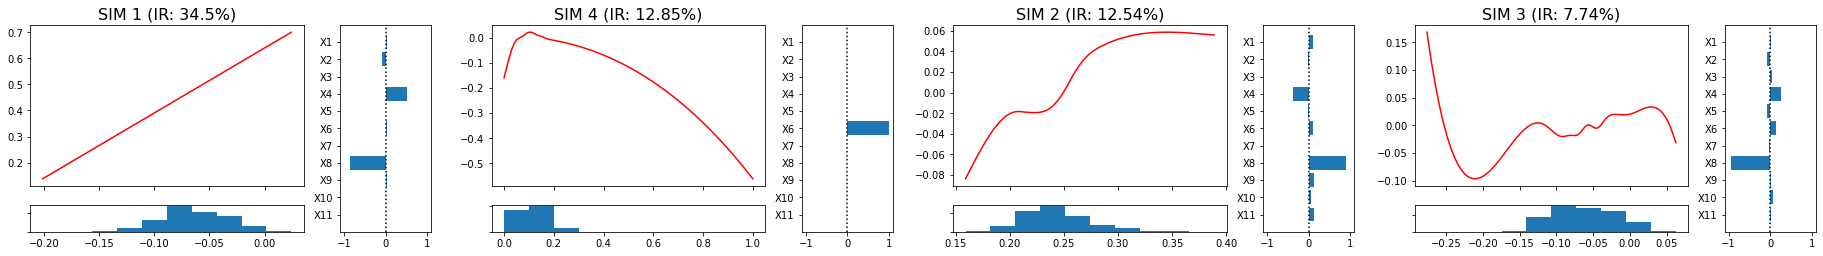

In [13]:
vb = 'wine_white'
save_nm = 'real_'+vb
data_loader = load_regression_data(vb)
plot_all_figures_real(data_loader,save_nm,data_type,random_state=0)

---------- SeqStein-Ortho ----------


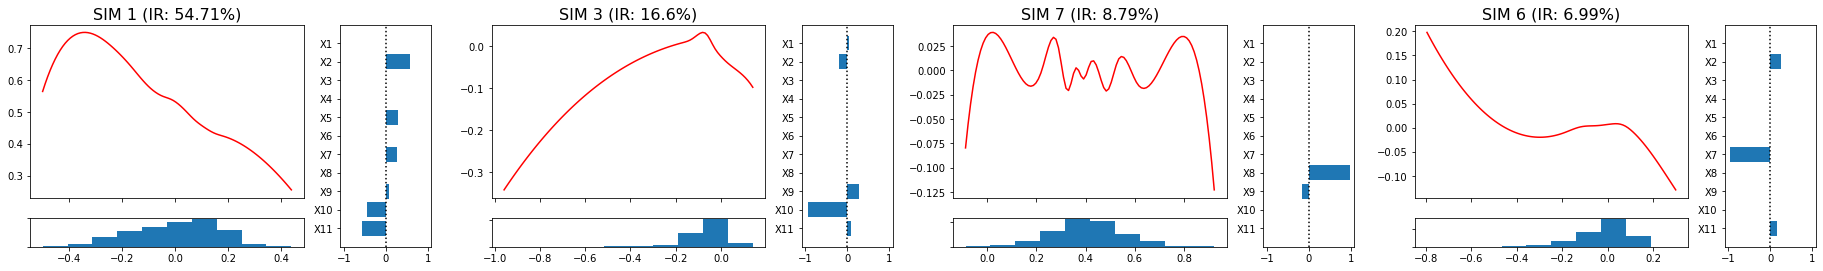

---------- SeqStein-NonOrtho ----------


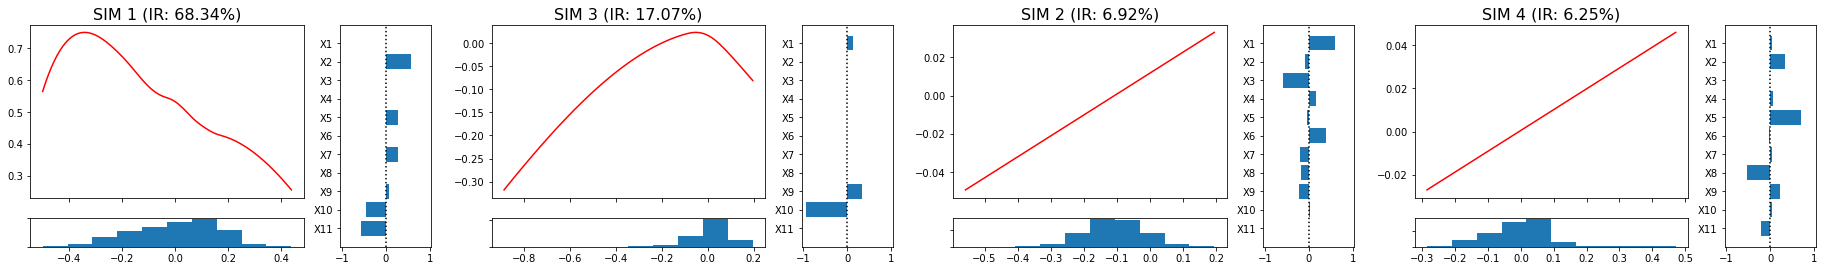

In [14]:
vb = 'wine_red'
save_nm = 'real_'+vb
data_loader = load_regression_data(vb)
plot_all_figures_real(data_loader,save_nm,data_type,random_state=1)